In [4]:
import numpy as np
from scipy.io import loadmat
import torch
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset

class MatDataset(Dataset):
    def __init__(self, mat_files):
        self.mat_files = mat_files
        # Determine the max_length once during initialization
        self.max_length = self.determine_max_length()

    def determine_max_length(self):
        max_length = 0
        for file in self.mat_files:
            mat_data = loadmat(file, squeeze_me=True, struct_as_record=False)
            length = len(mat_data['id'])
            if length > max_length:
                max_length = length
        return max_length

    def __len__(self):
        return len(self.mat_files)

    def __getitem__(self, idx):
        # Load one .mat file
        file = self.mat_files[idx]
        mat_data = loadmat(file, squeeze_me=True, struct_as_record=False)
            
        # Extract input and output variables and reshape them
        inputs = np.hstack([mat_data[var].reshape(-1, 1) for var in ['id', 'id_ref', 'IntErr_Id', 'IntErr_Iq', 'iq', 'iq_ref']])
        outputs = np.hstack([mat_data[var].reshape(-1, 1) for var in ['v_md', 'v_mq']])
            
        # Pad the sequences to self.max_length
        inputs = pad_sequences(inputs, maxlen=self.max_length, padding='post')
        outputs = pad_sequences(outputs, maxlen=self.max_length, padding='post')
        
        # Convert numpy arrays to torch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.float32)
        
        return inputs, outputs


In [5]:
import os

data_dir = "D:/Data"  # Directory containing all .mat files

all_mat_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.mat')]

np.random.shuffle(all_mat_files)  # Shuffle the list of .mat files

# divide the data into train, test and validation sets
# 70% percent of the data is used for training, 15% for testing and 15% for validation

num_files = len(all_mat_files)
train_files = all_mat_files[:int(0.7 * num_files)] 
test_files = all_mat_files[int(0.7 * num_files):int(0.85 * num_files)]
val_files = all_mat_files[int(0.85 * num_files):]

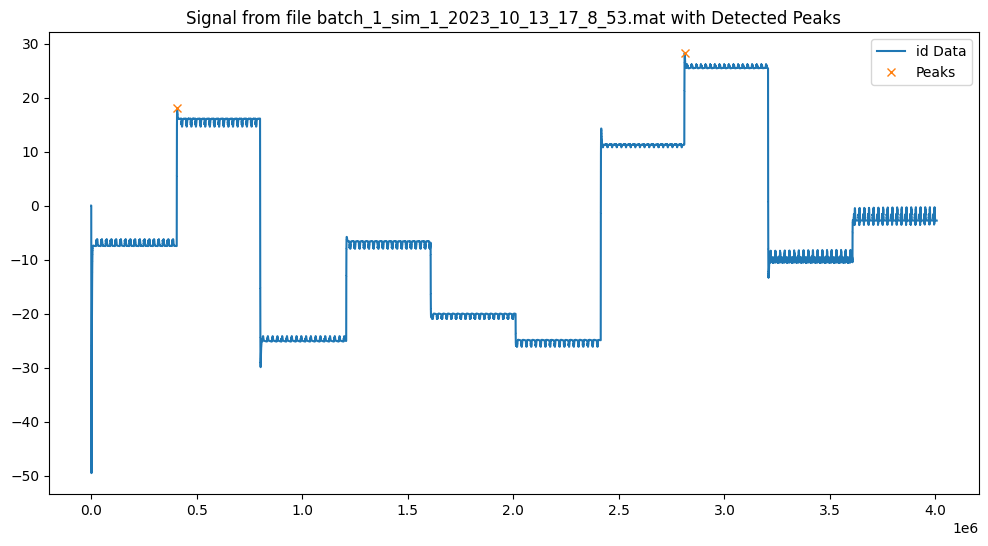

Number of data points between peaks: [2405035]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import find_peaks
import random
import os

# Get a list of all .mat files
data_dir = "D:/Data"
all_mat_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.mat')]

# Select a random .mat file
random_file = random.choice(all_mat_files)

# Load the .mat file
mat_data = loadmat(random_file, squeeze_me=True, struct_as_record=False)

# Extract 'id' variable from the loaded .mat file
id_data = mat_data['id']

# Dynamically determine distance and height for peak detection
mean_signal = np.mean(id_data)
std_signal = np.std(id_data)
height_threshold = mean_signal + std_signal

# The distance is inversely proportional to the average absolute derivative
avg_derivative = np.mean(np.abs(np.diff(id_data)))
distance_threshold = int(1 / avg_derivative * 1000)  # scaled by 1000 for better granularity

# Detect peaks
peak_indices, _ = find_peaks(id_data, distance=distance_threshold, height=height_threshold)

# Calculate differences between consecutive peak indices
differences = np.diff(peak_indices)

# Plot the 'id' data with detected peaks
plt.figure(figsize=(12, 6))
plt.plot(id_data, label='id Data')
plt.plot(peak_indices, id_data[peak_indices], "x", label='Peaks')
plt.title(f'Signal from file {os.path.basename(random_file)} with Detected Peaks')
plt.legend()
plt.show()

# Print number of data points between peaks
print("Number of data points between peaks:", differences)
